In [4]:
import numpy as np
import pandas as pd
import glob
import sys,os

In [5]:
from PIL import Image
import cv2
# import matplotlib.pyplot as plt

In [6]:
# import json
# import pickle
import re
from tqdm import tqdm
from pathlib import Path

### 0.API

In [34]:
id_standard_df = pd.read_csv('/nas/chenyi/datasets_nas/labelMap/standard/id2class99_chenyi.csv')
id_use_df = id_standard_df[id_standard_df['use']>=0]

In [91]:
shbg_map = pd.read_excel('./dada_det/data/shoe_bag11k_map.xlsx')

In [13]:
# with open('./data/haowei34k_map_stand.json', 'w') as f:
#     json.dump(hw2stand, f)

In [7]:
def get_list2dict(k_list, v_list):
    d = {}
    for item in zip(k_list, v_list):
        d[item[0]] = item[1]
    return d

In [8]:
model_label_map = {
    0: 10,  # 鞋子
    1: 8,  # 包包
    2: 4,  # 上装
    3: 5,  # 裤子
    4: 6,  # 裙子
    5: 7,  # 连体装
}

In [17]:
l2_map_l1 = get_list2dict( id_use_df['label99'].values, id_use_df['label_l1'].values)

In [18]:
id2chi_l2 = get_list2dict(id_use_df['label2_chi'].values, id_use_df['label99'].values)

In [19]:
id2eng_l2 = get_list2dict(id_use_df['label99'].values, id_use_df['label2_eng'].values)

In [20]:
id2chi_l1 = get_list2dict(id_use_df['label_l1'].values, id_use_df['label1_chi'].values)

In [21]:
id2eng_l1 = get_list2dict(id_use_df['label_l1'].values, id_use_df['label1_eng'].values)

In [22]:
id2model_l1 = get_list2dict(model_label_map.values(), model_label_map.keys())

In [92]:
shbg_map_dict = get_list2dict(shbg_map[shbg_map.columns[0]], shbg_map[shbg_map.columns[1]])

### 1.Dataset Information.

In [9]:
# 训练路径.
!tree -d -L 1 /home/chenyi/workspace/yolov5/datasets/

/home/chenyi/workspace/yolov5/datasets/
├── coco128
├── dadet100kv2
├── dadet100kv3_june
├── dadet100kv4_1_june
├── dadet100kv4_june
├── deepedia
├── deepedia_catg6
├── deepedia_catg8
├── haowei_bag_shoe
├── hwpedia
├── hwpedia80k
├── tuneGallery10k
├── tuneGallery5k
├── tuneQuery10k
└── validation_all

15 directories


In [ ]:
# 图片路径.
!tree -d -L 2 /home/chenyi/workspace/dataset/data/dada_det/

/home/chenyi/workspace/yolov5/datasets/hwpedia80k
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories


### 2.统计数据集

In [ ]:
df = dada_sb_df[dada_sb_df['label_model']>=0]

In [ ]:
df.describe()

,1,2,4,5,6,7,label_model
count,14119.000000,14119.000000,14119.000000,14119.000000,14119.000000,14119.000000,14119.000000
mean,1555.057228,1786.059069,290.286989,391.856364,1255.860967,1391.431546,0.404349
std,1016.166383,1127.583063,324.846913,393.565724,898.908348,941.415005,0.591684
min,450.000000,383.000000,1.000000,1.000000,52.000000,99.000000,0.000000
25%,800.000000,800.000000,71.000000,119.000000,624.000000,690.000000,0.000000
50%,1080.000000,1350.000000,184.000000,268.000000,858.000000,1009.000000,0.000000
75%,2448.000000,2880.000000,390.000000,530.000000,1892.500000,2064.000000,1.000000
max,6000.000000,4860.000000,2448.000000,3490.000000,5180.000000,4630.000000,5.000000


#### 二级标签

In [ ]:
df.head(2)

,0,1,2,3,4,5,6,7,img_sp,label_model
0,/nas/chenyi/datasets_nas/dada_labelme/labelme_...,3024,4032,包,685,719,2231,3806,/home/chenyi/workspace/dataset/data/dada_det/s...,1
1,/nas/chenyi/datasets_nas/dada_labelme/labelme_...,800,800,包,206,1,650,778,/home/chenyi/workspace/dataset/data/dada_det/s...,1


In [ ]:
df.value_counts('label_model')

label_model
0    8859
1    5022
2     115
3      58
4      42
5      23
dtype: int64

In [ ]:
counter = df.value_counts('label_model').sort_index()

In [ ]:
id_list = np.array(counter.axes)[0]
numbers = counter.values
name_list = [str(x) + ':' + str(id2eng_l2[hw2stand[str(x)][0]]) for x in id_list]

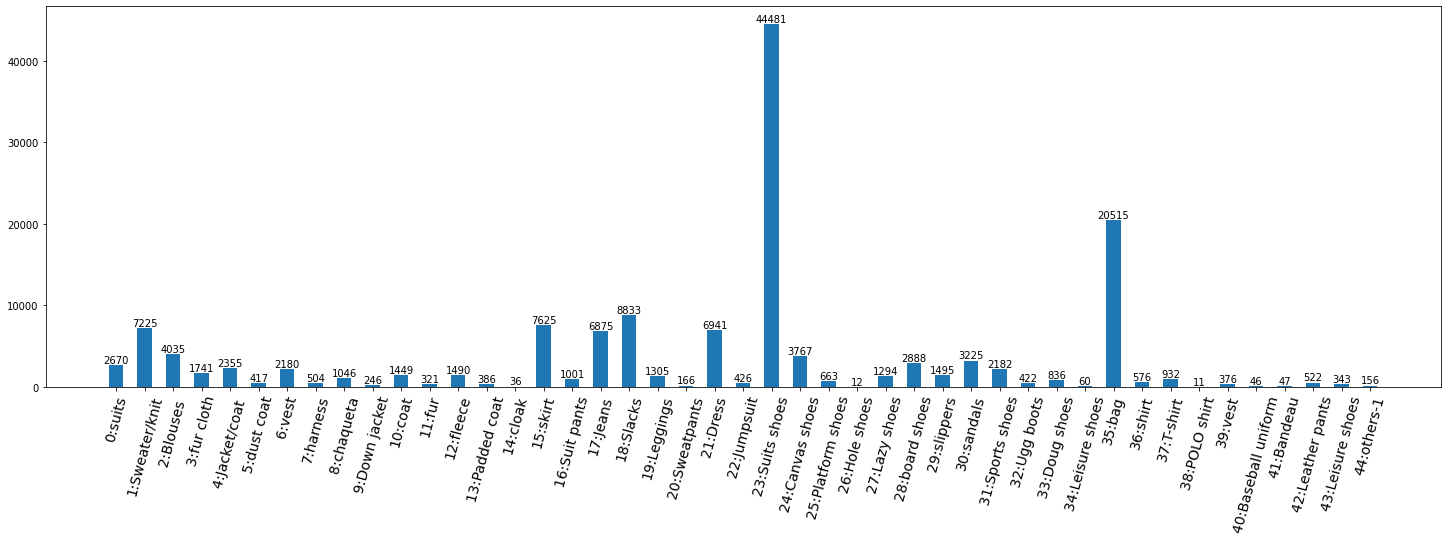

In [ ]:
plt.figure(figsize=(25, 7))
plt.xticks(list(range(len(name_list))), name_list, rotation=75, fontsize=14)
plt.bar(name_list, numbers, width=0.5)  # 绘制y刻度标签
for a, b in zip(name_list, numbers):
    plt.text(a, b, b, ha='center', va='bottom')
plt.show()

#### 一级标签

In [ ]:
counter = df.value_counts('label_model').sort_index()

In [ ]:
id2model_l1

In [ ]:
id2eng_l1

{-1: 'other-1',
 4: 'upperbody',
 5: 'pants',
 6: 'skirt',
 7: 'wholebody',
 8: 'bag',
 10: 'shoe'}

In [ ]:
id_list = np.array(counter.axes)[0]
numbers = counter.values
name_list = [str(x) + ':' + id2eng_l1[model_label_map[x]] for x in id_list]

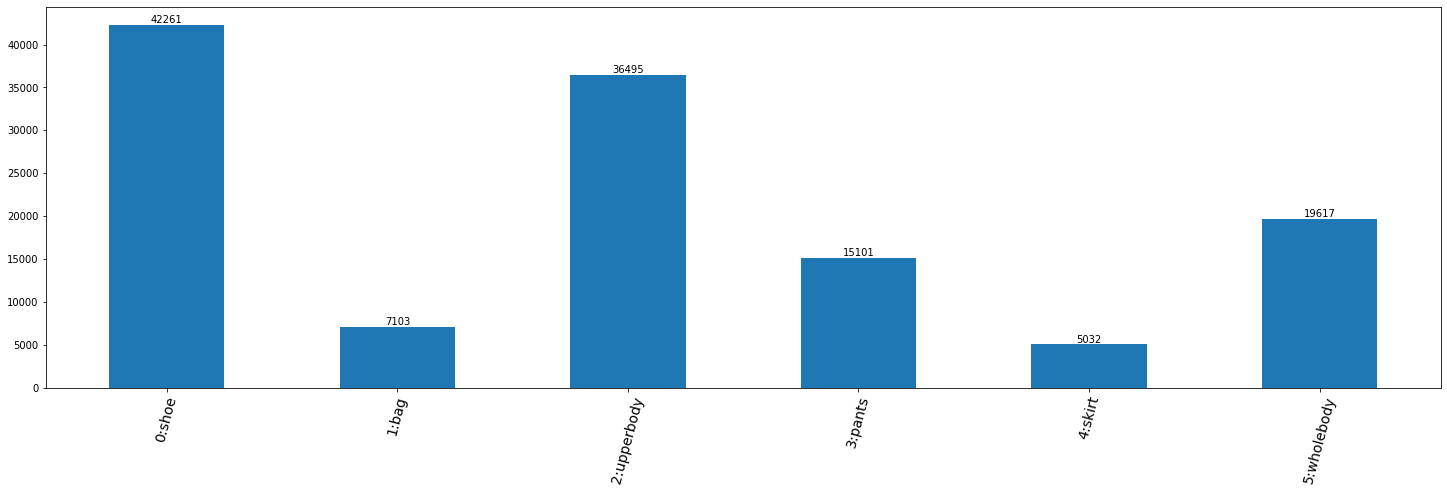

In [ ]:
plt.figure(figsize=(25, 7))
plt.xticks(list(range(len(name_list))), name_list, rotation=75, fontsize=14)
plt.bar(name_list, numbers, width=0.5)  # 绘制y刻度标签
for a, b in zip(name_list, numbers):
    plt.text(a, b, b, ha='center', va='bottom')
plt.show()

In [ ]:
!ls /nas/chenyi/dataset_apparel_nas/

haowei34k  haowei34k_conf7.csv	haowei34k.tar  haowei_conf07_multi  openfashion


In [ ]:
hw_data_p = '/nas/chenyi/dataset_apparel_nas/haowei34k_conf7.csv'

In [ ]:
hw_data_df = pd.read_csv(hw_data_p)

In [ ]:
hw_data_df.head()

,id,img_path,label_path,label_1,一级分类,label_2,二级分类,x_c,y_c,w,h,confidence
0,20141215090521289,/nas/lichangjian/ok_data/20141215090521289.jpg,/nas/lichangjian/labels/20141215090521289.txt,4,上装,0,小西装,0.454839,0.320250,0.412903,0.362912,0.961302
1,20141215090521289,/nas/lichangjian/ok_data/20141215090521289.jpg,/nas/lichangjian/labels/20141215090521289.txt,5,裤子,18,休闲裤,0.440323,0.627986,0.296774,0.470990,0.953829
2,20140924211054180,/nas/lichangjian/ok_data/20140924211054180.jpg,/nas/lichangjian/labels/20140924211054180.txt,4,上装,0,小西装,0.542500,0.343897,0.198333,0.387324,0.920288
3,20140924211054180,/nas/lichangjian/ok_data/20140924211054180.jpg,/nas/lichangjian/labels/20140924211054180.txt,5,裤子,16,西装裤,0.538333,0.660798,0.156667,0.485915,0.915438
4,20141204122102902,/nas/lichangjian/ok_data/20141204122102902.jpg,/nas/lichangjian/labels/20141204122102902.txt,4,上装,4,夹克/外套,0.486250,0.341667,0.322500,0.286667,0.781202


In [ ]:
counter_hw = hw_data_df['label_2'].value_counts()

In [ ]:
id_list = np.array(counter_hw.axes)[0]
numbers = counter_hw.values
name_list = [str(x) + ':' + names[x][1] for x in id_list]

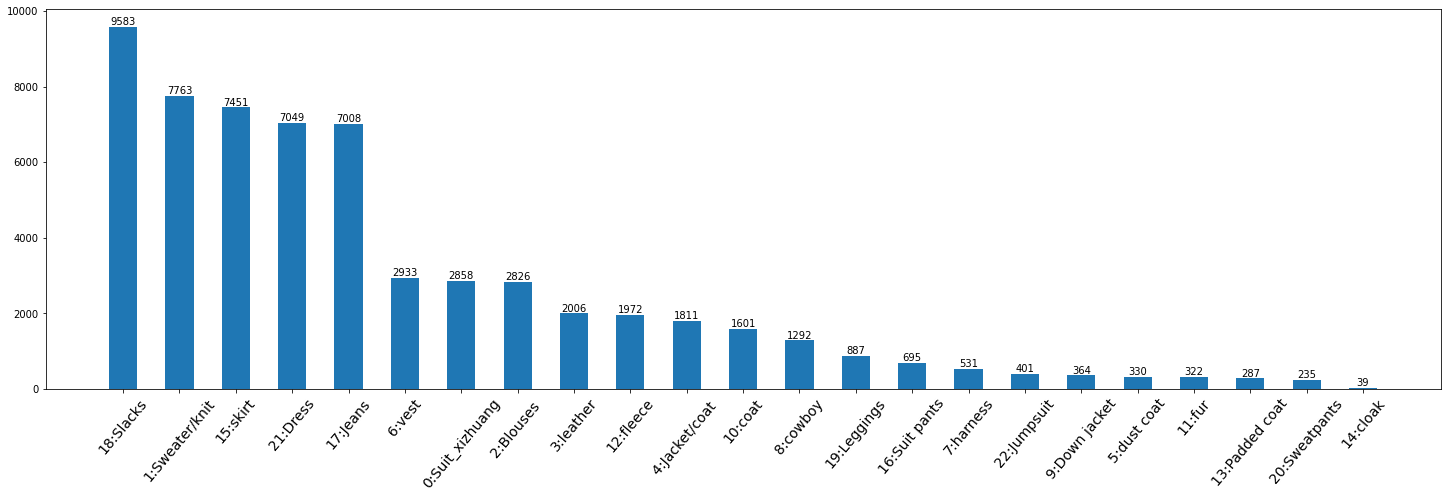

In [ ]:
plt.figure(figsize=(25, 7))
plt.xticks(list(range(len(name_list))), name_list, rotation=50, fontsize=14)
plt.bar(name_list, numbers, width=0.5)  # 绘制y刻度标签
for a, b in zip(name_list, numbers):
    plt.text(a, b, b, ha='center', va='bottom')
plt.show()

### slink_df构建:生成软连接的path

In [4]:
root  = Path('/home/chenyi/workspace/yolov5/datasets')

In [5]:
!tree -d -L 1 $root

/home/chenyi/workspace/yolov5/datasets
├── coco128
├── dadet100kv2
├── dadet100kv3_june
├── dadet100kv4_june
├── deepedia
├── deepedia_catg6
├── deepedia_catg8
├── haowei_bag_shoe
├── hwpedia
├── hwpedia80k
├── tuneGallery10k
├── tuneGallery5k
├── tuneQuery10k
└── validation_all

14 directories


#### 直接读取slink.csv

In [10]:
def folder_change(chg_df, origin_folder, folder_name):
    chg_df['img_tp'] = chg_df['img_tp'].apply(lambda x:x.replace(f'/datasets/{origin_folder}/images/', f'/datasets/{folder_name}/images/'))
    chg_df['label_tp'] = chg_df['label_tp'].apply(lambda x:x.replace(f'/datasets/{origin_folder}/labels/', f'/datasets/{folder_name}/labels/'))
    return chg_df

In [11]:
def name_change(chg_df, folder_name):
    chg_df['img_tp'] = chg_df['img_tp'].apply(lambda x: '{0}/{1}_{2}'.format(Path(x).parent, folder_name, Path(x).name))
    chg_df['label_tp'] = chg_df['label_tp'].apply(lambda x: '{0}/{1}_{2}'.format(Path(x).parent, folder_name, Path(x).name))
    return chg_df

In [490]:
# name_stand = ['img_sp', 'img_tp', 'label_sp', 'label_tp']
# slink_df.rename(columns={slink_df.columns[4]:name_stand[0],
#                         slink_df.columns[3]:name_stand[1],
#                         slink_df.columns[1]:name_stand[2],
#                         slink_df.columns[2]:name_stand[3]},
#                inplace=True)

In [12]:
!tree -d -L 1 /home/chenyi/workspace/yolov5/datasets/

/home/chenyi/workspace/yolov5/datasets/
├── coco128
├── dadet100kv2
├── dadet100kv3_june
├── dadet100kv4_1_june
├── dadet100kv4_june
├── deepedia
├── deepedia_catg6
├── deepedia_catg8
├── haowei_bag_shoe
├── hwpedia
├── hwpedia80k
├── tuneGallery10k
├── tuneGallery5k
├── tuneQuery10k
└── validation_all

15 directories


In [282]:
slink_df = pd.concat([fashion_slink, hw_slink], axis=0)

In [279]:
fashion_slink = pd.read_csv('../fashionpedia/data/fashionpedia6_slink.csv')
hw_slink = pd.read_csv('../haowei34k/data/hw34k_level1_slink.csv')

In [231]:
# shbg5k_slink = pd.read_csv('../dada_det/data/shoeBag5k0515/shoeBag0515_slink_df.csv')
# skirt5k_slink = pd.read_csv('../deepfashion2/data/skirt_slink.csv')
# shbg11k_slink = pd.read_csv('../dada_det/data/shoeBag10k0530/shoe_bag11k_may_slink.csv')
# wholebody5k_slink = pd.read_csv('../dada_det/data/wholebody5k0610/wholebody5k_slin_dfk.csv')
syserror_slink = pd.read_csv('../dada_det/data/sys_error_sample/sys_error_slin_dfk.csv')
# len(shbg5k_slink), len(skirt5k_slink), len(shbg11k_slink), len(wholebody5k_slink)

In [63]:
origin_folder = 'hwpedia80k'
folder_name = 'dadet100kv4_june'
fashion_slink = folder_change(fashion_slink, origin_folder, folder_name)

In [64]:
origin_folder = 'dadet100kv2'
folder_name = 'dadet100kv4_june'
hw_slink = folder_change(hw_slink, origin_folder, folder_name)

In [138]:
origin_folder = 'dadet100kv1'
folder_name = 'dadet100kv4_june'
skirt5k_slink = folder_change(skirt5k_slink, origin_folder, folder_name)

In [66]:
origin_folder = 'dadet100kv1'
folder_name = 'dadet100kv4_june'
shbg11k_slink = folder_change(shbg11k_slink, origin_folder, folder_name)

In [98]:
origin_folder = 'dadet100kv3_june'
folder_name = 'dadet100kv4_june'
wholebody5k_slink = folder_change(wholebody5k_slink, origin_folder, folder_name)

In [232]:
origin_folder = 'dadet100kv3_june'
folder_name = 'dadet100kv4_1_june'
syserror_slink = folder_change(syserror_slink, origin_folder, folder_name)
syserror_slink = name_change(syserror_slink, 'syserror60')

In [22]:
# slink_df = pd.concat([dav4_df, syserror_slink], axis=0)
slink_df = pd.read_csv('./data/hwpedia_slink_df.csv')

In [31]:
len(slink_df),len(slink_df.drop_duplicates('label_tp'))
slink_df['target'] = slink_df['img_tp'].apply(lambda x: re.findall('datasets/(.*?)/images/', x)[0])
slink_df.value_counts('target')

target
tuneGallery10k    10000
dtype: int64

In [24]:
!ls ./data/tuneDataset/

tuneGallery10k_slink_df.csv  tuneQuery10k_slink_df.csv
tuneGallery5k_slink_df.csv


In [38]:
origin_folder = 'tuneGallery10k'
folder_name = 'tuneGallery5k'
slink_df = folder_change(slink_df, origin_folder, folder_name)

In [39]:
slink_df.head(1).values

array([['af2bffd5ce2402f83592229b732bd20c',
        '/home/chenyi/workspace/dataset/labels/labels6/fashionpedia/labels/train/af2bffd5ce2402f83592229b732bd20c.txt',
        '/home/chenyi/workspace/yolov5/datasets/tuneGallery5k/labels/train/af2bffd5ce2402f83592229b732bd20c.txt',
        '/home/chenyi/workspace/yolov5/datasets/tuneGallery5k/images/train/af2bffd5ce2402f83592229b732bd20c.jpg',
        '/home/chenyi/workspace/dataset/data/data_fashionpedia/train/af2bffd5ce2402f83592229b732bd20c.jpg',
        'tuneGallery10k']], dtype=object)

In [40]:
slink_sample = slink_df.sample(int(5e3))

In [41]:
len(slink_sample)

5000

In [42]:
slink_df = slink_sample

In [43]:
# folder_name = 'dadet100kv4_june'
folder_name

'tuneGallery5k'

In [44]:
# slink_df.to_csv(f'data/{folder_name}_slink_df.csv', index=False)
slink_sample.to_csv(f'data/tuneDataset/{folder_name}_slink_df.csv', index=False)

In [45]:
slink_df['mode'] = slink_df['img_tp'].apply(lambda x: re.findall('/images/(.*?)/', x)[0])
slink_df['id'] = slink_df['img_tp'].apply(lambda x: Path(Path(x).parts[-2]) /Path(x).stem)
slink_df.value_counts('mode'),len(slink_df.drop_duplicates('id')),len(slink_df)

(mode
 train    4312
 val       688
 dtype: int64,
 5000,
 5000)

### 生成sym link

In [168]:
!tree -d -L 1 /home/chenyi/workspace/yolov5/datasets/

/home/chenyi/workspace/yolov5/datasets/
├── coco128
├── dadet100kv2
├── dadet100kv3_june
├── dadet100kv4_june
├── deepedia
├── deepedia_catg6
├── deepedia_catg8
├── haowei_bag_shoe
├── hwpedia
├── hwpedia80k
├── tuneGallery10k
├── tuneGallery5k
├── tuneQuery10k
└── validation_all

14 directories


In [222]:
slink_df = 

In [76]:
slink_df = pd.read_csv('data/tuneDataset/tuneGallery10k_slink_df.csv')
folder_name = 'tuneGallery10k'

In [77]:
root = '/home/chenyi/workspace/yolov5/datasets/'

In [78]:
# 产生路径
import shutil
# folder_name = 'dadet100kv4_june'
# folder_name = folder_name
folder_root = Path(root) /folder_name
# folder_root = root
folder1 = ['images', 'labels']
folder2 = ['train', 'val']
# if folder_root.is_dir() and True:
#     shutil.rmtree(folder_root)
# for f1 in folder1:
#     for f2 in folder2:
#         tg = folder_root / f1 / f2
#         tg.mkdir(parents=True)   

In [79]:
!tree -d -L 2 $folder_root

/home/chenyi/workspace/yolov5/datasets/tuneGallery10k
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories


In [80]:
for p in glob.glob(f'{folder_root}/*/*/*'):
    if Path(p).is_symlink():
        Path(p).unlink()

In [81]:
folder_root, len(glob.glob(f'{folder_root}/images/*/*.jpg')), len(glob.glob(f'{folder_root}/labels/*/*.txt'))

(PosixPath('/home/chenyi/workspace/yolov5/datasets/tuneGallery10k'), 0, 0)

In [82]:
slink_df.head(1).values

array([['20160426020017708',
        '/home/chenyi/workspace/dataset/labels/labels6/haowei34k/labels/train/20160426020017708.txt',
        '/home/chenyi/workspace/yolov5/datasets/tuneGallery10k/labels/train/20160426020017708.txt',
        '/home/chenyi/workspace/yolov5/datasets/tuneGallery10k/images/train/20160426020017708.jpg',
        '/home/chenyi/workspace/dataset/data/haowei34k/images/train/20160426020017708.jpg',
        'tuneGallery10k']], dtype=object)

In [83]:
%%time
for p in slink_df['label_tp'].values:
    if Path(p).is_symlink():
        Path(p).unlink()
_ = slink_df.apply(lambda row: Path.symlink_to(Path(row['label_tp']), Path(row['label_sp'])), axis=1)
# _ = slink_df.apply(lambda row: os.symlink(str(row['label_sp']), str(row['label_tp'])), axis=1)

CPU times: user 455 ms, sys: 208 ms, total: 664 ms
Wall time: 663 ms


In [84]:
%%time
for p in slink_df['img_tp'].values:
    if Path(p).is_symlink():
        Path(p).unlink()
_ = slink_df.apply(lambda row: Path.symlink_to(Path(row['img_tp']), Path(row['img_sp'])), axis=1)

CPU times: user 574 ms, sys: 181 ms, total: 755 ms
Wall time: 755 ms


In [85]:
len(slink_df),len(glob.glob(f'{folder_root}/images/*/*.jpg')), len(glob.glob(f'{folder_root}/labels/*/*.txt'))

(10000, 10000, 10000)

In [86]:
p = str(slink_df['label_tp'].values[0])
!cat $p

0 0.135000 0.922500 0.240000 0.071667
0 0.625000 0.940000 0.100000 0.090000
2 0.615000 0.385833 0.340000 0.331667
3 0.465000 0.684167 0.550000 0.391667


#### 核查软连接

In [87]:
!tree -d -L 1 /home/chenyi/workspace/yolov5/datasets/

/home/chenyi/workspace/yolov5/datasets/
├── coco128
├── dadet100kv2
├── dadet100kv3_june
├── dadet100kv4_1_june
├── dadet100kv4_june
├── deepedia
├── deepedia_catg6
├── deepedia_catg8
├── haowei_bag_shoe
├── hwpedia
├── hwpedia80k
├── tuneGallery10k
├── tuneGallery5k
├── tuneQuery10k
└── validation_all

15 directories


In [88]:
# folder_name = 'hwpedia'
folder_name = folder_name
root = f'/home/chenyi/workspace/yolov5/datasets/{folder_name}'
!tree  -d -L 2 $root

/home/chenyi/workspace/yolov5/datasets/tuneGallery10k
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories


In [89]:
def check_syslink(root, mode='images'):
    subfix = '.txt' if mode=='labels' else '.jpg'
    flag_list = [os.path.isfile(os.readlink(p)) for p in glob.glob(f'{root}/{mode}/*/*{subfix}')]
    txt_df = pd.DataFrame()
    txt_df['flag'] = flag_list
    return txt_df.value_counts('flag')

In [90]:
%%time
check_syslink(root, mode='images')

CPU times: user 42.5 ms, sys: 62.6 ms, total: 105 ms
Wall time: 107 ms


flag
True    10000
dtype: int64

In [91]:
%%time
check_syslink(root, mode='labels')

CPU times: user 58.5 ms, sys: 51.7 ms, total: 110 ms
Wall time: 110 ms


flag
True    10000
dtype: int64

#### 对现有数据拷贝软连接

In [15]:
img_list = glob.glob('/home/chenyi/workspace/yolov5/datasets/hw_pedia_true/images/*/*')
len(img_list)

83370

In [18]:
label_list = glob.glob('/home/chenyi/workspace/yolov5/datasets/hw_pedia_true/labels/*/*')
len(label_list)

83370

In [16]:
img_t_list = [p.replace('hw_pedia_true', 'dadet100kv1') for p in img_list]

In [19]:
label_t_list = [p.replace('hw_pedia_true', 'dadet100kv1') for p in label_list]

In [22]:
df = pd.DataFrame()
df['img_sp'] = img_list
df['label_sp'] = label_list
df['img_tp'] = img_t_list
df['label_tp'] = label_t_list

In [97]:
slink_df.head(2)

,img_sp,label_sp,label_tp,img_tp
0,/home/chenyi/workspace/dataset/data/haowei34k/...,/home/chenyi/workspace/dataset/labels/dada_det...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/yolov5/datasets/dadet10...
1,/home/chenyi/workspace/dataset/data/haowei34k/...,/home/chenyi/workspace/dataset/labels/dada_det...,/home/chenyi/workspace/yolov5/datasets/dadet10...,/home/chenyi/workspace/yolov5/datasets/dadet10...


In [99]:
slink_df.tail(2).values

array([['/home/chenyi/workspace/dataset/data/haowei34k/haowei23/images/c357e734-24e3-4aa2-b738-ddce8c5997f4.jpg',
        PosixPath('/home/chenyi/workspace/dataset/labels/dada_det/labels202205/shoeBag5k0515/val/c357e734-24e3-4aa2-b738-ddce8c5997f4.txt'),
        PosixPath('/home/chenyi/workspace/yolov5/datasets/dadet100kv1/labels/val/c357e734-24e3-4aa2-b738-ddce8c5997f4.txt'),
        PosixPath('/home/chenyi/workspace/yolov5/datasets/dadet100kv1/images/val/c357e734-24e3-4aa2-b738-ddce8c5997f4.jpg')],
       ['/home/chenyi/workspace/dataset/data/haowei34k/haowei23/images/e42ac97d-67ab-4961-acae-56bd7746929a.jpg',
        PosixPath('/home/chenyi/workspace/dataset/labels/dada_det/labels202205/shoeBag5k0515/train/e42ac97d-67ab-4961-acae-56bd7746929a.txt'),
        PosixPath('/home/chenyi/workspace/yolov5/datasets/dadet100kv1/labels/train/e42ac97d-67ab-4961-acae-56bd7746929a.txt'),
        PosixPath('/home/chenyi/workspace/yolov5/datasets/dadet100kv1/images/train/e42ac97d-67ab-4961-acae-56b

In [ ]:
df.head(2)

,fname,label1_chi,bx1,bx2,bx3,bx4,label8,img_sp,width,height,label_sp,mode,label_tp
0,008e4ecc-068a-4e94-af76-05fb5ecf699b.jpg,正装女鞋,0.417708,0.802083,0.435417,0.306250,0,/home/chenyi/workspace/dataset/data/haowei34k/...,960,960,/home/chenyi/workspace/dataset/haowei34k/label...,train,/home/chenyi/workspace/dataset/labels/dada_det...
1,03af19b7-ef94-4736-b33b-f92ae549aba8.jpg,包,0.595812,0.554543,0.724609,0.890914,1,/home/chenyi/workspace/dataset/data/haowei34k/...,4608,3456,/home/chenyi/workspace/dataset/haowei34k/label...,train,/home/chenyi/workspace/dataset/labels/dada_det...


In [90]:
slink_df = pd.DataFrame()
drop_df = df.drop_duplicates('img_sp')
slink_df['img_sp'] = drop_df['img_sp']
slink_df['label_sp'] = drop_df['label_tp']

In [94]:
troot = Path('/home/chenyi/workspace/yolov5/datasets/dadet100kv1/')

In [95]:
slink_df['label_tp'] = slink_df['label_sp'].apply(lambda x: troot /'labels' /Path(x).parts[-2] /Path(x).parts[-1])

In [96]:
slink_df['img_tp'] = slink_df['label_sp'].apply(lambda x: troot /'images' /Path(x).parts[-2] /Path(x).parts[-1])
slink_df['img_tp'] = slink_df['img_tp'].apply(lambda x: x.with_suffix('.jpg'))

In [100]:
slink_df.to_csv('./data/shoeBag5k0515/shoeBag0515_slink_df.csv', index=False)